# Lab Assignment 09: Recurrent Network Architectures


### Dataset Selection

Select a dataset identically to lab two. That is, the dataset must be text data (or time series sequence). In terms of generalization performance, it is helpful to have a large dataset of similar sized text documents. It is fine to perform binary classification or multi-class classification. The classification can be "many-to-one" or "many-to-many" sequence classification, whichever you feel more comfortable with. 

### Preparation (40 points total)
[20 points] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).   

[10 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

[10 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

### Modeling (50 points total)

[25 points] Investigate at least two different recurrent network architectures (perhaps LSTM and GRU). Adjust hyper-parameters of the networks as needed to improve generalization performance. 

[25 points] Use the method of cross validation and evaluation metric that you argued for at the beginning of the lab. Visualize the best results of the RNNs.   

### Exceptional Work (10 points total)
You have free reign to provide additional analyses.

One idea: Use more than a single chain of LSTMs or GRUs (i.e., use multiple parallel chains). 

Another Idea: Try to create a RNN for generating novel text. 

In [3]:
import pandas as pd
import numpy as np
import os
from scipy.misc import imread
import matplotlib.pyplot as plt
import random
import warnings
from keras.datasets import reuters
from keras.preprocessing import sequence
from keras import utils


Using TensorFlow backend.


In [24]:
top_words = 5000
(X_train, y_train), (X_test, y_test) = reuters.load_data(path="reuters.npz",
                                                         num_words=top_words,
                                                         skip_top=0,
                                                         maxlen=None,
                                                         test_split=0.2,
                                                         seed=113,
                                                         start_char=1,
                                                         oov_char=2,
                                                         index_from=3)

In [25]:
# truncate and pad input sequences
max_art_length = 500
NUM_CLASSES = 46
X_train = sequence.pad_sequences(X_train, maxlen=max_art_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_art_length)

y_train_ohe = utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = utils.to_categorical(y_test, NUM_CLASSES)

In [26]:
print(type(X_train),X_train.shape)
print(type(X_train[0]),X_train[0].shape)
print('Vocabulary size:', np.max(X_train))
print(y_train.shape, np.min(y_train), np.max(y_train))

<class 'numpy.ndarray'> (8982, 500)
<class 'numpy.ndarray'> (500,)
Vocabulary size: 4999
(8982,) 0 45


In [27]:
from keras.models import Sequential, Input, Model
from keras.layers import Dense
from keras.layers import LSTM, GRU, SimpleRNN
from keras.layers.embeddings import Embedding

EMBED_SIZE = 50
rnns = []
input_holder = Input(shape=(X_train.shape[1], ))
shared_embed = Embedding(top_words, 
                EMBED_SIZE, 
                input_length=max_art_length)(input_holder)

for func in [SimpleRNN, LSTM, GRU]:
    
    x = func(50,dropout=0.2, recurrent_dropout=0.2)(shared_embed)
    x = Dense(NUM_CLASSES, activation='sigmoid')(x)
    rnn=Model(inputs=input_holder,outputs=x)
    rnn.compile(loss='categorical_crossentropy', 
                  optimizer='rmsprop', 
                  metrics=['accuracy'])
    print(rnn.summary())
    rnns.append(rnn)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 500, 50)           250000    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 50)                5050      
_________________________________________________________________
dense_10 (Dense)             (None, 46)                2346      
Total params: 257,396
Trainable params: 257,396
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 500)               0         
_________________________________________________________________

In [28]:
results = []
for rnn, name in zip(rnns,['simple','lstm','gru']):
    print('=======',name,'========')
    start_time = time.time()
    history = rnn.fit(X_train, y_train_ohe, epochs=3, batch_size=64, validation_data=(X_test, y_test_ohe))
    
    average_time_per_epoch = (time.time() - start_time) / epochs

    results.append((history, average_time_per_epoch))

======= simple ========
Train on 8982 samples, validate on 2246 samples
Epoch 1/3
8982/8982 [==============================] - 24s - loss: 3.4893 - acc: 0.2246 - val_loss: 2.8112 - val_acc: 0.3615
Epoch 2/3
8982/8982 [==============================] - 30s - loss: 2.5561 - acc: 0.3517 - val_loss: 2.4422 - val_acc: 0.3620
Epoch 3/3
8982/8982 [==============================] - 34s - loss: 2.4225 - acc: 0.3517 - val_loss: 2.4216 - val_acc: 0.3620
======= lstm ========
Train on 8982 samples, validate on 2246 samples
Epoch 1/3
8982/8982 [==============================] - 82s - loss: 2.6916 - acc: 0.3487 - val_loss: 2.4388 - val_acc: 0.3620
Epoch 2/3
8982/8982 [==============================] - 80s - loss: 2.4132 - acc: 0.3517 - val_loss: 2.4215 - val_acc: 0.3620
Epoch 3/3
8982/8982 [==============================] - 75s - loss: 2.4115 - acc: 0.3517 - val_loss: 2.4191 - val_acc: 0.3620
======= gru ========
Train on 8982 samples, validate on 2246 samples
Epoch 1/3
8982/8982 [==================

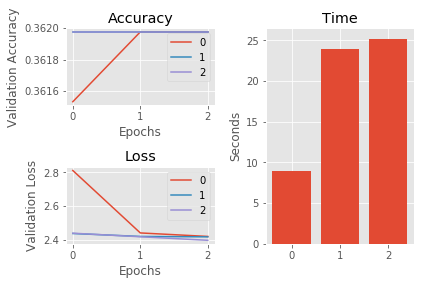

In [29]:
modes = [0, 1, 2]
plt.style.use('ggplot')
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax1.set_title('Accuracy')
ax1.set_ylabel('Validation Accuracy')
ax1.set_xlabel('Epochs')
ax2 = plt.subplot2grid((2, 2), (1, 0))
ax2.set_title('Loss')
ax2.set_ylabel('Validation Loss')
ax2.set_xlabel('Epochs')
ax3 = plt.subplot2grid((2, 2), (0, 1), rowspan=2)
ax3.set_title('Time')
ax3.set_ylabel('Seconds')
for mode, result in zip(modes, results):
    ax1.plot(result[0].epoch, result[0].history['val_acc'], label=mode)
    ax2.plot(result[0].epoch, result[0].history['val_loss'], label=mode)
ax1.legend()
ax2.legend()
ax3.bar(np.arange(len(results)), [x[1] for x in results],
        tick_label=modes, align='center')
plt.tight_layout()
plt.show()

In [30]:
print(X_train[100])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    1  367 1394  169   65   87  209   30  306  228   10  803  305   96
    5  196   15   10  523    2 3006  293  484    2 1440    2    8  145    7
   10 1670    6   10  294  517  237    2  367    2    7 2477 1177  483 1440
    2    8  367 1394    4  169  387   66  209   30 2344  652 1496    9  209
   30 2564  228   10  803  305   96    5  196   15   51   36 1457   24 1345
    5    4  196  150   10  523  320   64  992    2   13  367  190  297   64
   85 1692    6    2  122    9   36 1457   24  269 4753   27  367  212  114
   45   30 3

In [11]:
'''Example script to generate text from Nietzsche's writings.

At least 20 epochs are required before the generated text
starts sounding coherent.

It is recommended to run this script on GPU, as recurrent
networks are quite computationally intensive.

If you try this script on new data, make sure your corpus
has at least ~100k characters. ~1M is better.
'''

from __future__ import print_function
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys

path = get_file('nietzsche.txt', origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')
text = open(path).read().lower()
print('corpus length:', len(text))

chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

print('Vectorization...')
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1


# build the model: a single LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)


def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

# train the model, output generated text after each iteration
for iteration in range(1, 60):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model.fit(X, y,
              batch_size=128,
              epochs=1)

    start_index = random.randint(0, len(text) - maxlen - 1)

    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print()
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x[0, t, char_indices[char]] = 1.

            preds = model.predict(x, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()


corpus length: 600893
total chars: 57
nb sequences: 200285
Vectorization...
Build model...

--------------------------------------------------
Iteration 1
Epoch 1/1
200285/200285 [==============================] - 202s - loss: 1.9842   

----- diversity: 0.2
----- Generating with seed: "he form of subject- and
ego-superstition"
he form of subject- and
ego-superstitions, and the is and supersible that in the conscioning and seal and the intermanific that is the supersition of the have that is the every that in the every of the preature in the is the to the seases of the way and interment of the every in the exister that in the ale something the self-constioning that is the free surcession of the ender that the eremance of the every that in the ears and subfecti

----- diversity: 0.5
----- Generating with seed: "he form of subject- and
ego-superstition"
he form of subject- and
ego-superstition of has the ears and intreation, had the action that the than that in that he is ranger and ill 

KeyboardInterrupt: 

In [19]:
 # LSTM and CNN for sequence classification in the IMDB dataset
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset but only keep the top n words, zero the rest
top_words = 5000
(X_train, y_train), (X_test, y_test) = reuters.load_data(path="reuters.npz",
                                                         num_words=top_words,
                                                         skip_top=0,
                                                         maxlen=None,
                                                         test_split=0.2,
                                                         seed=113,
                                                         start_char=1,
                                                         oov_char=2,
                                                         index_from=3)
# truncate and pad input sequences
max_art_length = 500
NUM_CLASSES = 46
X_train = sequence.pad_sequences(X_train, maxlen=max_art_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_art_length)

y_train_ohe = utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = utils.to_categorical(y_test, NUM_CLASSES)
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(NUM_CLASSES, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train_ohe, epochs=3, batch_size=64)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test_ohe, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 500, 32)           3104      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 250, 32)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_7 (Dense)              (None, 46)                4646      
Total params: 220,950
Trainable params: 220,950
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
8982/8982 [==============================] - 52s - loss: 2.6679 - acc: 0.3500    
Epoch 2/3
8982/8982 [==================

In [22]:
import time
import numpy as np
import matplotlib.pyplot as plt

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM, Dropout
from keras.datasets import imdb

max_features = 20000
max_length = 80
embedding_dim = 256
batch_size = 128
epochs = 10
modes = [0, 1, 2]

print('Loading data...')
(X_train, y_train), (X_test, y_test) = reuters.load_data(path="reuters.npz",
                                                         num_words=top_words,
                                                         skip_top=0,
                                                         maxlen=None,
                                                         test_split=0.2,
                                                         seed=113,
                                                         start_char=1,
                                                         oov_char=2,
                                                         index_from=3)
                                                         
X_train = sequence.pad_sequences(X_train, max_length)
X_test = sequence.pad_sequences(X_test, max_length)

# Compile and train different models while meauring performance.
results = []
for mode in modes:
    print('Testing mode: implementation={}'.format(mode))

    model = Sequential()
    model.add(Embedding(max_features, embedding_dim,
                        input_length=max_length))
    model.add(Dropout(0.2))
    model.add(LSTM(embedding_dim,
                   dropout=0.2,
                   recurrent_dropout=0.2,
                   implementation=mode))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    start_time = time.time()
    history = model.fit(X_train, y_train_ohe,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(X_test, y_test_ohe))
    average_time_per_epoch = (time.time() - start_time) / epochs

    results.append((history, average_time_per_epoch))

# Compare models' accuracy, loss and elapsed time per epoch.
plt.style.use('ggplot')
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax1.set_title('Accuracy')
ax1.set_ylabel('Validation Accuracy')
ax1.set_xlabel('Epochs')
ax2 = plt.subplot2grid((2, 2), (1, 0))
ax2.set_title('Loss')
ax2.set_ylabel('Validation Loss')
ax2.set_xlabel('Epochs')
ax3 = plt.subplot2grid((2, 2), (0, 1), rowspan=2)
ax3.set_title('Time')
ax3.set_ylabel('Seconds')
for mode, result in zip(modes, results):
    ax1.plot(result[0].epoch, result[0].history['val_acc'], label=mode)
    ax2.plot(result[0].epoch, result[0].history['val_loss'], label=mode)
ax1.legend()
ax2.legend()
ax3.bar(np.arange(len(results)), [x[1] for x in results],
        tick_label=modes, align='center')
plt.tight_layout()
plt.show()

Loading data...
Testing mode: implementation=0


ValueError: Error when checking model target: expected dense_9 to have shape (None, 1) but got array with shape (8982, 46)

In [31]:
vocabulary = reuters.get_word_index(path="reuters_word_index.json")
vocabulary_inv = dict((v, k) for k, v in vocabulary.items())

In [52]:
(X_train, y_train), (X_test, y_test) = reuters.load_data(path="reuters.npz",
                                                         num_words=None,
                                                         skip_top=0,
                                                         maxlen=None,
                                                         test_split=0.2,
                                                         seed=113,
                                                         start_char=1,
                                                         oov_char=2,
                                                         index_from=3)
sentence = ""
for i in X_train[1234]:
    if i != 0:
        sentence = sentence + str(vocabulary_inv[i]) + " "

In [53]:
print(sentence)

the in has would waste where when 3 at part mln stock he enough for against 2 actual said export heavily news allocated opec and selling in when quarter pay and 325 brings stock mln stock he petrochemical in has would there about minister 720 customer by matters he bank breakup entity it ec central 3 reduction in record 17 2 politically opec 400 was japan owns initiative are h 3 in 720 51 011 export fourth that in banks senior said at matters in waste where when said in compared analysts 3 in compared geigy part mln a capital by reflected where u likely cautioned in take shares 3 main henley oil allow and 325 in ghana clear fourth cts and managing be what shareholders quota and lusinchi in allocated opec pct dlrs 


In [54]:
import amzn

ImportError: No module named 'amzn'

In [56]:
data = np.load('data/ourdata.npy')

In [61]:
data[0][1]


'When watching A Bug\'s Life for the first time in a long while, I couldn\'t help but see the comparisons with last year\'s Happy Feet. As far as the main storyline goes, they are very similar, an outcast doing what he can to fit in while also attempting to be special. It just goes to show you how much better that film could have been without its liberal diatribe conclusion. A lot of people disagree with me when I say that I really like Pixar\'s sophomore effort. Sure it doesn\'t manage to capture the splendor of Toy Story, nor is the animation out of this world. However, the story is top-notch and the characters are wonderful to spend time with. With plenty of laughs and a moral center to boot, I could watch this one just as much as the studio\'s other classics.<br /><br />There is a lot about finding strength from within to conquer all odds here. Between our lead Flick needing to keep his self-esteem up to save his colony, the colony needing to open their eyes onto a new way of livin